# Demo of `apclattice`
    Alan Morningstar and Steven Li
    Princeton University APC 524 Final Project
    December 2020

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# add to path so we can find the source code
import os
import sys
sys.path.insert(0, os.path.abspath('..'))
# import apclattice functionality
from src.dof import DiscreteDOF
from src.unitcell import HoneycombUnitCell
from src.lattice import Lattice
from src.gate import HoneycombGate

### Encapsulate demo code in a class

In [2]:
class Demo:
    """Demoing the apclattice project."""
    
    def __init__(self, L):
        """Initialize demo.
        
        :param L: List of two integers. Number of unit cells in each dimension of the honeycomb lattice.
        """
        # honeycomb unit cell, two sites per cell, 0 or 1 particles per site
        spc = 2
        max_charge = 1
        dof = spc * [DiscreteDOF(0, max_charge)]
        self.uc = HoneycombUnitCell(dof)
        # for now leave the system without particles and create the lattice
        nsites = np.prod(L)*spc
        vals = np.zeros(nsites, dtype=int)
        self.lat = Lattice(self.uc, L, vals, periodic=True)
        # gate to enact local dynamics
        self.gate = HoneycombGate(self.uc)
        
    def plot(self, s=10):
        """Make an image of the lattice and values of degrees of freedom on each site.
        
        :param s: Size of marker passed to plt.scatter.
        """
        # xy coordinates of each site
        x, y = self.lat.positions.T
        # color tan if 0, teal if 1
        cmap = np.asarray(['#E1BE6A', '#40B0A6'])
        # plot the positions
        fig, ax = plt.subplots()
        ax.scatter(x, y, marker='o', c = cmap[self.lat.vals], s=s)
        # labels
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title('Honeycomb Lattice')
        
    def charge_blob(self):
        """Put a blob of charge in the middle of the lattice."""
        # center of the lattice
        mean_r = np.mean(self.lat.positions, axis=0)
        # distance from center
        delta_r = np.sqrt(np.sum((self.lat.positions - mean_r)**2, axis=1))
        # order sites by proximity to center
        order = np.argsort(delta_r)
        # fill half of sites closest to center with charge
        cutoff = self.lat.nsites // 2
        max_charge = 1
        self.lat.vals[order[0:cutoff]] = max_charge
        
    def dynamics(self, t):
        """Run the dynamics of the lattice. Apply gates serially at random locations.
        
        :param t: Positive integer. The number of gates applied is t*nsites.
        """
        for i in range(t*self.lat.nsites):
            rand_i = np.random.choice(range(self.lat.nsites))
            self.gate(self.lat, rand_i)

### Initialize the demo

In [3]:
# extent of lattice
L = [25, 25]
# create demo
d = Demo(L)

### Plot the empty lattice

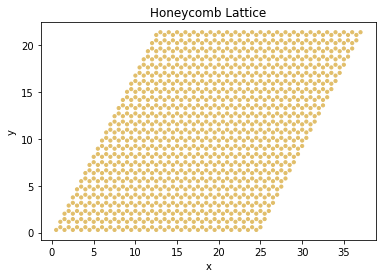

In [4]:
# plot lattice
d.plot()

### Put charge in the lattice and plot it

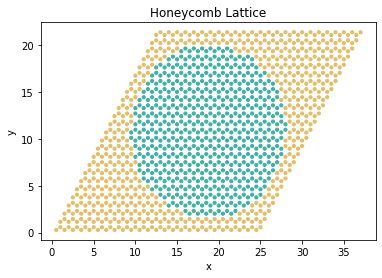

In [5]:
d.charge_blob()
d.plot()

### Run rounds of dynamics on the lattice to let the charge diffuse and plot

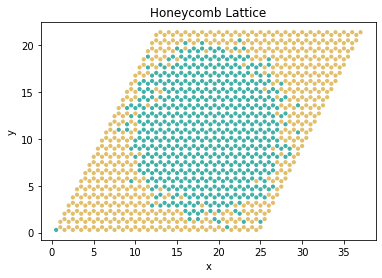

In [6]:
# timestep, apply dt * nsites gates
dt = 1
d.dynamics(dt)
d.plot()

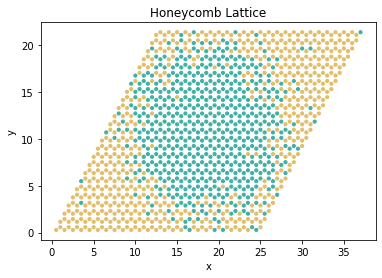

In [7]:
dt = 2
d.dynamics(dt)
d.plot()

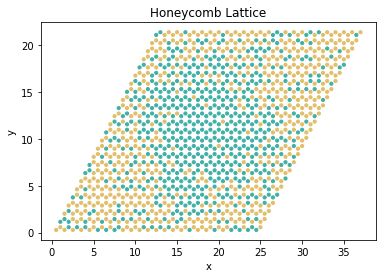

In [8]:
dt = 8
d.dynamics(dt)
d.plot()

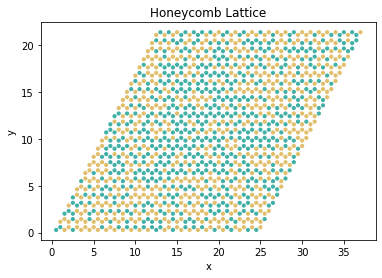

In [9]:
dt = 16
d.dynamics(dt)
d.plot()

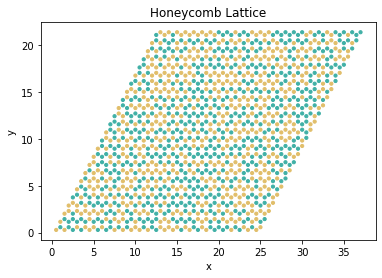

In [10]:
dt = 32
d.dynamics(dt)
d.plot()

### A bit of profiling

In [11]:
dt = 10
%timeit d.dynamics(dt)

3.76 s ± 213 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%prun d.dynamics(dt)

         2187505 function calls (2087505 primitive calls) in 8.901 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    12500    3.367    0.000    3.367    0.000 {method 'choice' of 'numpy.random.mtrand.RandomState' objects}
    50000    0.670    0.000    2.479    0.000 lattice.py:104(__wrap)
162500/62500    0.523    0.000    1.893    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
    12500    0.352    0.000    4.333    0.000 gate.py:125(<listcomp>)
    62500    0.333    0.000    0.684    0.000 numerictypes.py:360(issubdtype)
    62500    0.312    0.000    1.436    0.000 lattice.py:68(__contains__)
   125000    0.287    0.000    0.287    0.000 {built-in method numpy.array}
    50000    0.231    0.000    1.465    0.000 function_base.py:4616(append)
    12500    0.175    0.000    5.420    0.000 gate.py:116(__call__)
    50000    0.171    0.000    3.981    0.000 lattice.py:115(coords_to_ind)
    5

From `prun` we can see that most of the time is spent in `np.random.randint` sampling new local states to update the lattice with. 